In [27]:
from Deriv import *
from Boundaries import *
from Dirichlet import *
from Neumann import *
from PeriodicExt import *
from GenCircuits import *

Generate quantum circuits in Pennylane that block encode the various boundary conditions

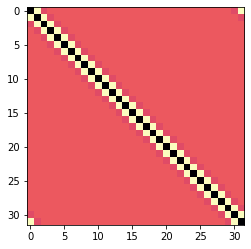

In [3]:
N = 32
periodicLCU(N, p= 3, show_BE=True)
#dirichletLCU(N, show_BE=True)
#neumannLCU(N, show_BE=True)

Generate matrices for various boundary value problems

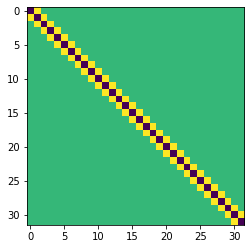

In [4]:
#1d Dirichlet with boundary conditions on endpoints
N = 32
deriv = Derivatives(2, N, 1)
d_bvp = SimpleDirichletBCs(deriv)
mat = d_bvp.constructMat()
plt.imshow(mat.toarray())
plt.show()



1D Dirichlet BVP with non-simply connected domain, with values specified on interior grid points

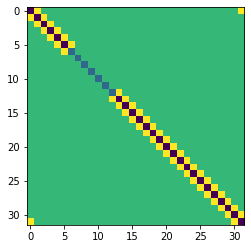

In [7]:
#1d Dirichlet with boundary conditions specified on interior elements

l_pt = 6
r_pt = 12

deriv = Derivatives(2,N,p=1)
bndry_data = DirBoundaryData([l_pt,r_pt],[x for x in range(l_pt)]+[x for x in range(r_pt,N)], [x for x in range(l_pt+1,r_pt)])
bc_problem = nonSimpleDirichletBC1d(deriv,bndry_data)
mat = bc_problem.constructMat()
plt.imshow(mat.toarray())
plt.show()

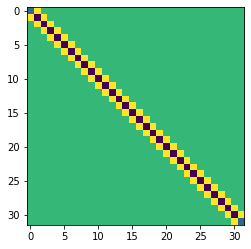

In [9]:
p =1 
deriv = Derivatives(2, N, p)
n_bvp = SimpleNeumannBCs(deriv)
rhs = np.ones(N)
mat = n_bvp.constructMat()
plt.imshow(mat.toarray())
plt.show()

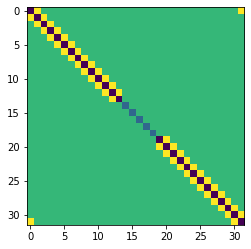

In [12]:
#1d Neumann BVP with non-simply connected domain

l_pt = N//2 -3
r_pt = N//2 + 3
interior = [x for x in range(N) if x not in range(l_pt,r_pt+1)]
bndry_vals = [0,0]
rhs = np.zeros(N)
for x in interior:
    rhs[x] = 1/N**2
rhs[l_pt] = 0
rhs[r_pt] = 0

deriv = Derivatives(2,N,p)
bndry_data = NeumBoundaryData([l_pt,r_pt],[x for x in range(l_pt)]+[x for x in range(r_pt,N)], [x for x in range(l_pt+1,r_pt)])
bc_problem = nonSimpleDirichletBC1d(deriv,bndry_data)
deriv = Derivatives(2, N, p)
n_bvp = nonSimpleNeumannBC1d(deriv, bndry_data)
mat = n_bvp.constructMat()
plt.imshow(mat.toarray())
plt.show()

Projection based method for solving BVP on non-simply connected domain, square hole

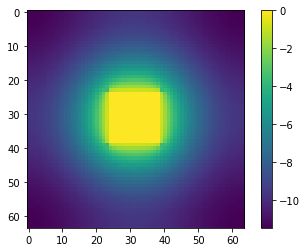

In [106]:
#2d Dirichlet problem with square hole in the center of the domain
N=64
deriv = Derivatives(2,N,p)
width = 16
#center
x0 = N//2-1
y0 = x0
r = width//2
#everything on 1d boundary of square
bndry_pts1d = [x0 - r,x0+r]
#everything but the 1d square boundary and its interior interior
interior = [x for x in range(x0-r)] + [x for x in range(x0+r+1,N)]
#everything inside of 
outside = [x for x in range(x0-r+1,x0+r)]
bndry_and_outside = bndry_pts1d+outside
bndry_data = DirBoundaryData(bndry_pts1d, interior, outside)
#Form 1d matrix for interior dirichlet problem
dir_bvp = nonSimpleDirichletBC1d(deriv,bndry_data)
periodic = deriv.fdMat()
dirichlet = dir_bvp.constructMat()
#form 2d matrix
#We have PBC's on the rows/columns that don't overlap with the hole and non-simple dirichlet BVP on those that do
mat2d = kron(periodic, projOp(N, interior))
mat2d += kron(dirichlet, projOp(N,bndry_and_outside))
mat2d += kron(projOp(N, interior), periodic)
mat2d += kron(projOp(N,bndry_and_outside),dirichlet)

#form rhs, set boundary and exterior values to zero, construct forcing function over interior grid points
rhs2d = np.zeros(N**2)
for i in range(N):
    for j in range(N):
        if np.abs(i - N//2) > r or np.abs(j - N//2) > r:
            rhs2d[i+N*j] =  1/N


u2d = spsolve(mat2d,rhs2d)
u2d = u2d.reshape((N,N))
img = plt.imshow(u2d)
plt.colorbar(img)
plt.show()

L Shaped domain with oscillating force function

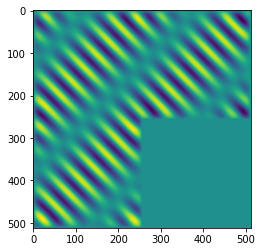

In [101]:

#L SHAPE
N = 512
width = N//2
grid = -np.ones((N,N))
for i in range(N):
    for j in range(N):
        grid[i,j] = LshapeFn(N, width, (i,j))

interior = [i + N*j for i in range(N) for j in range(N) if grid[i,j] == 0]
bndry = [i + N*j for i in range(N) for j in range(N) if grid[i,j] == 1]
exterior = [i + N*j for i in range(N) for j in range(N) if grid[i,j] == 2]
#Form periodic Laplacian and projection on to domain interior
lap2d = Derivatives(2, N, p, dim = 2).fdMat()
proj_int = projOp(N**2, interior)
#Project Laplacian so that rows on the boundary or outside are set to zero
lap_int = proj_int@lap2d
#Add projection onto boundary 
lap_int_bndry = lap_int + projOp(N**2,bndry)
#The matrix will generically be singular since there will be a bunch of rows of all zeros 
#If we are promised that the rhs is zero on the exterior of the domain, we may choose to
#instead pad the matrix with 1's on the diagonal of rows corresponding to exterior points. We do this here
lap_total = lap_int_bndry +projOp(N**2, exterior)

rhs = np.zeros(N**2)
rhs[interior] = 1/N*np.array([np.cos(2*(i+j)/N*np.pi)*np.sin(17*(j-i)/N*np.pi) for i in range(N) for j in range(N) if grid[i,j] == 0])
u = spsolve(lap_total, rhs)
plt.imshow(u.reshape((N,N)))
plt.show()

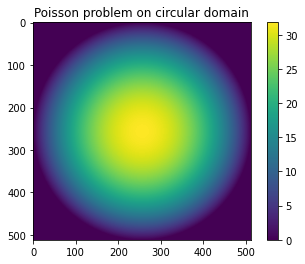

In [ ]:
#RASTERIZED CIRCLE SHAPE
from circle import *
N = 512
width = N//2
grid = np.ones((N,N))

interior_g, bndry_g, exterior_g = points_inside_circle(N, N//2-1, N//2,N//2)
#convert grid to 1d indices
interior = [x[0]+N*x[1] for x in interior_g]
bndry = [x[0]+N*x[1] for x in bndry_g]
exterior = [x[0]+N*x[1] for x in exterior_g]

#Form periodic Laplacian and projection on to domain interior
lap2d = Derivatives(2, N, p, dim = 2).fdMat()
proj_int = projOp(N**2, interior)
#Project Laplacian so that rows on the boundary or outside are set to zero
lap_int = proj_int@lap2d
#Add projection onto boundary 
lap_int_bndry = lap_int + projOp(N**2,bndry)
#The matrix will generically be singular since there will be a bunch of rows of all zeros 
#If we are promised that the rhs is zero on the exterior of the domain, we may choose to
#instead pad the matrix with 1's on the diagonal of rows corresponding to exterior points. We do this here
lap_total = lap_int_bndry +projOp(N**2, exterior)

rhs = np.zeros(N**2)
rhs[interior] = 1/N*np.array([-1 for x in interior])
u = spsolve(lap_total, rhs)
img = plt.imshow(u.reshape((N,N)))
plt.colorbar(img)
plt.show()

Periodic extension in 1D

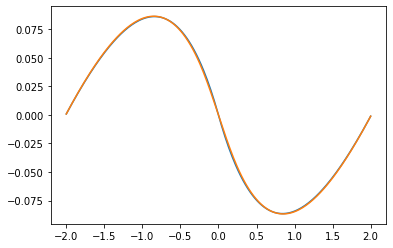

In [23]:
###ODD EXTENSION EXAMPLE
N = 128
f = lambda x: np.exp(-x)
oddExtension = lambda x: naiveOdd(f, x, end_points=[0,2])
grid = np.linspace(-2,2,2*N)
oddVals = [oddExtension(x) for x in grid]
#As k gets smaller, the mollifier becomes more sharply resolved
oddSmooth = oddExtendSmooth(f, N, end_points=[0,2], k=20)

fdMat = Derivatives(2, 2*N, p =6).fdMat()

u = spsolve(fdMat, oddVals)
norm = np.linalg.norm(u)
u /= norm


u_smooth = spsolve(fdMat, oddSmooth)
norm = np.linalg.norm(u_smooth)
u_smooth /= norm

plt.plot(grid, u)
plt.plot(grid, u_smooth)
plt.show()

2144961853535846.5
2144952297965748.5


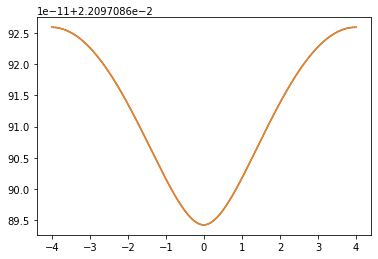

In [55]:
#EVEN EXTENSION EXAMPLE

N = 1024
f = lambda x: np.exp(-x)
evenExtension = lambda x: naiveEven(f, x, end_points=[0,4])
grid = np.linspace(-4,4,2*N)
evenVals = [evenExtension(x) for x in grid]

#As k gets smaller, the mollifier becomes more sharply resolved
evenSmooth = evenExtendSmooth(f, N, end_points=[0,4], k=15)
#As p incrases, the solution smoothes 
fdMat = Derivatives(2, 2*N, p =6).fdMat()

u = spsolve(fdMat, evenVals)
norm = np.linalg.norm(u)
u /= norm
print(norm)


u_smooth = spsolve(fdMat, evenSmooth)
norm = np.linalg.norm(u_smooth)
u_smooth /= norm
print(norm)

plt.plot(grid, u)
plt.plot(grid, u_smooth)
plt.show()